# **CONVOLUTIONAL NEURAL NETWORK (CNN)**

## Problem

Train a CNN on the [horses-or-humans dataset](https://www.tensorflow.org/datasets/catalog/horses_or_humans).

Note: Use tfds.


## Initialize

In [1]:
import cv2
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

## Dataset

Get the datase using [this jupyter notebook](02a-Horse-Human-Dataset-Preparation.ipynb).

**Dataset directories**

In [3]:
# root directory
ROO_DIR = '../.tmp/horses-or-humans'

# directory for the subsets
DIR_TRAIN = ROO_DIR + '/train'
DIR_VALID = ROO_DIR + '/valid'
DIR_TEST = ROO_DIR + '/test'

# directory for log
DIR_LOG = '02-logs'

## Data Augmentation

[See tensorflow docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

**Note**
- We perform augmentation only for the training images.
- We normalize all training, validation, and testing images.
- We do not need to shuffle the validation and testing images.

In [4]:
INPUT_SIZE = (300, 300, 3)
BATCH_SIZE = 16

# generate image data with normalization and augmentation
train_datagen = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2),
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
)

# train data generator
train_generator = train_datagen.flow_from_directory(
    directory=DIR_TRAIN,
    target_size=INPUT_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=0
)

# generate image data only with normalization
test_datagen = ImageDataGenerator(
    rescale=1 / 255.,
)

# validation data generator
valid_generator = test_datagen.flow_from_directory(
    directory=DIR_TEST,
    target_size=INPUT_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# test data generator
test_generator = test_datagen.flow_from_directory(
    directory=DIR_TEST,
    target_size=INPUT_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 822 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


#### Check one image

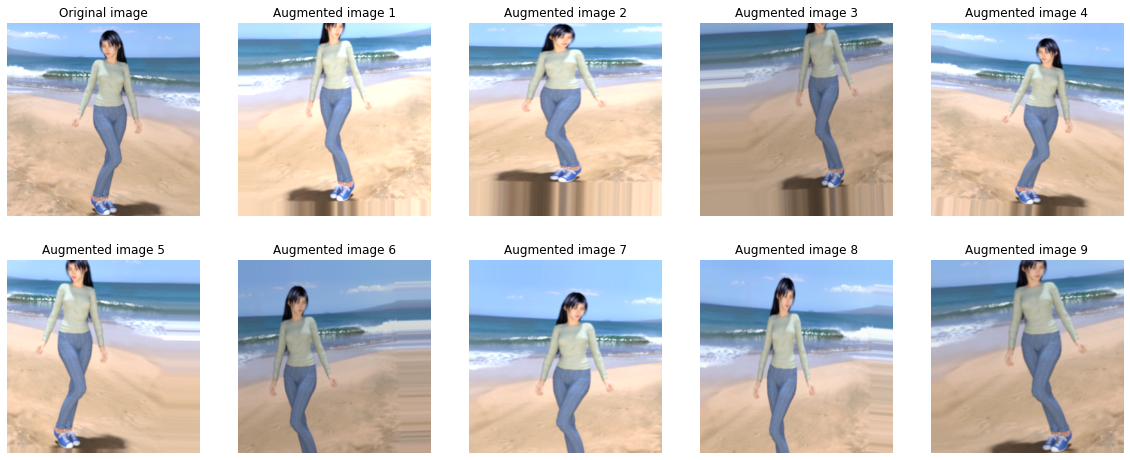

In [5]:
# get one image
img = cv2.imread(f'{DIR_TRAIN}/humans/human01-14.png')
# convert BGR to RGB
img = img[:, :, ::-1]

# show the original image
plt.figure(figsize=(20, 8))
plt.subplot(2,5,1)
plt.title('Original image')
plt.axis('off')
plt.imshow(img)

# get augmented images
for i in range(9):
    # perform random augmentation
    # NOTE: it performs all random transformation defined in 'train_datagen'
    # except the rescaling
    aug_img = train_datagen.random_transform(img)

    # convert float to uint8
    aug_img = aug_img.astype('uint8')

    # plot the figures
    plt.subplot(2,5,i+2)
    plt.title(f'Augmented image {i+1}')
    plt.axis('off')
    plt.imshow(aug_img)

plt.show()

## Model

**Note**
- The problem is binary classification.
- Use `'sigmoid'` activation function in the output layer.
- Use `'binary_crossentropy'` loss.

In [6]:
# input layer
input_tensor = Input(shape=INPUT_SIZE)

# convolution layers
x = Conv2D(32, 3, activation='relu')(input_tensor)
x = MaxPool2D()(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(256, 3, activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(256, 3, activation='relu')(x)
x = MaxPool2D()(x)

# fully-connected layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# output layer with 'sigmoid' activation function
output_tensor = Dense(1, activation='sigmoid')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile with 'binary_crossentropy' loss
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['acc'],
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0     

## Callback

- You can use [pre-defined callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).
- Or, you can define custom callback to have more control over what happens during the training or prediction.
[See more](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).

**`ReduceLROnPlateau()`**
- Reduces the learning rate by a factor (defined in `factor`)
if the monitored metric (defined in`monitor`) does not improve
for a number of consecutive eporchs (defined in `patience`).

**`EarlyStopping()`**
- Stops the training if the monitored metric (defined in`monitor`)
does not improve by a defined amount (`min_delta`)
for a number of consecutive eporchs (defined in `patience`).

**`TensorBoard()`**
- Enables tensorboard visualization.
- Launce from commandline: ```tensorboard --logdir=path_to_your_logs```

In [7]:
# reduce learning rate
reduce_rl = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=2
)

# stop training
early_stopping = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=2
)

# visualize in tensorboard
tensorboard = TensorBoard(log_dir=DIR_LOG)

# commandline from root directory:
# tensorboard --logdir=02-Computer-Vision/02-logs

## Training

**Note**
- The class 'humans' generally perform better than the class 'horses'.
- To force model to care more about 'horses', we used 'class weights'.
- Here, class weights are hand-picked, giving slightly more weight to classs 'horses'.

In [8]:
# train the model and save the history
hist = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=100,
    verbose=1,
    class_weight = [1.5, 1.],
    callbacks=[reduce_rl, early_stopping, tensorboard]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 16 steps
Epoch 1/100
52/52 [==============================] - 22s 423ms/step - loss: 0.7053 - acc: 0.5012 - val_loss: 0.6934 - val_acc: 0.3008
Epoch 2/100
52/52 [==============================] - 21s 408ms/step - loss: 0.6804 - acc: 0.5791 - val_loss: 0.7133 - val_acc: 0.5000
Epoch 3/100
52/52 [==============================] - 21s 396ms/step - loss: 0.6276 - acc: 0.6363 - val_loss: 0.6664 - val_acc: 0.6445
Epoch 4/100
52/52 [==============================] - 20s 391ms/step - loss: 0.4999 - acc: 0.7518 - val_loss: 0.7222 - val_acc: 0.6641
Epoch 5/100
52/52 [==============================] - 21s 403ms/step - loss: 0.4288 - acc: 0.7920 - val_loss: 0.6069 - val_acc: 0.8008
Epoch 6/100
52/52 [==============================] - 22s 425ms/step - loss: 0.4676 - acc: 0.8358 - val_loss: 2.1074 - val_acc: 0.6758
Epoch 7/100
52/52 [==============================] - 21s 399ms/step - loss: 0.2502 - acc: 0.9039 - val_l

**Save model**

`model.save()`
- Saves entire model (architecture, weight, and state).
- To load, use `tf.keras.models.load_model()`.

`model.save_weights()`
- Saves only the weights.
- To load, build the model first. Then, `model.load_weights`.

In [9]:
# save the entire model
model.save(DIR_LOG + '/cnn_model.h5', include_optimizer=False)

## Evauation

In [10]:
# get prediction on the test images
y_pred = model.predict(test_generator)
y_pred = y_pred > 0.5

**Confusion matrix**

In [11]:
# get true test labels
y_test = test_generator.labels

# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

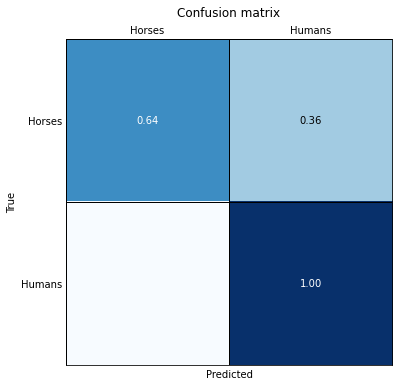

In [12]:
# get name of the classes
labels = list(test_generator.class_indices.keys())
# capitalize
labels = [l.capitalize() for l in labels]
# get indices of the classes
indices = list(test_generator.class_indices.values())

# figure for displaying the confusion matrix
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# display the confution matrix
cax = ax.matshow(conf_mat, cmap='Blues')

# show the values
for (i, j), z in np.ndenumerate(conf_mat):
    text_color = 'w' if i == j else 'k'
    if z < 0.005:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c=text_color)

# title and axis labels
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# show class names
plt.xticks(indices, labels)
plt.yticks(indices, labels)
ax.tick_params(axis='both', which='both', length=0)

# show grid lines
ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

plt.show()

**Other metrics**

In [13]:
# calculate precision, recall, and f1 score
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

In [14]:
# pandas data frame for storing the metrics
df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
},
    index=labels
)

# calculate the mean
df.loc['(Average)'] = df.mean()

# display
df

,Precision,Recall,F1-score
Horses,1.000000,0.640625,0.780952
Humans,0.735632,1.000000,0.847682
(Average),0.867816,0.820312,0.814317
